In [1]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [2]:
trainset= torchvision.datasets.CIFAR10(root='./train', train=True,download=True)
testset = torchvision.datasets.CIFAR10(root='./test', train=False,download=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./train/cifar-10-python.tar.gz to ./train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./test/cifar-10-python.tar.gz to ./test


In [3]:
valset,trainset= random_split(trainset,[10000,40000])

In [4]:
trainset[1]

(<PIL.Image.Image image mode=RGB size=32x32>, 7)

In [5]:
testset[1]

(<PIL.Image.Image image mode=RGB size=32x32>, 8)

In [6]:
#转化为numpy数组查看结果
image = np.array(trainset[1][0])
image

array([[[ 94, 138, 173],
        [ 94, 138, 173],
        [ 95, 139, 173],
        ...,
        [ 95, 141, 175],
        [ 95, 142, 175],
        [ 95, 143, 177]],

       [[ 94, 140, 174],
        [ 96, 141, 175],
        [ 97, 142, 176],
        ...,
        [ 98, 145, 179],
        [ 98, 146, 179],
        [ 97, 147, 180]],

       [[ 94, 140, 173],
        [ 94, 140, 173],
        [ 96, 141, 174],
        ...,
        [ 99, 146, 179],
        [ 99, 146, 179],
        [ 98, 147, 179]],

       ...,

       [[ 60,  52,  46],
        [ 34,  31,  29],
        [ 19,  19,  20],
        ...,
        [ 67,  52,  46],
        [ 65,  51,  45],
        [ 63,  49,  42]],

       [[ 66,  56,  49],
        [ 45,  40,  36],
        [ 24,  24,  23],
        ...,
        [ 83,  66,  56],
        [ 81,  65,  56],
        [ 81,  65,  55]],

       [[ 68,  58,  50],
        [ 54,  47,  41],
        [ 31,  27,  25],
        ...,
        [ 88,  71,  58],
        [ 87,  70,  58],
        [ 91,  73,  60]]

In [7]:
image = np.array(valset[1][0])
image

array([[[ 63,  56,  50],
        [ 64,  57,  51],
        [ 64,  57,  51],
        ...,
        [ 71,  66,  60],
        [ 69,  64,  58],
        [ 66,  62,  56]],

       [[ 67,  60,  54],
        [ 66,  59,  53],
        [ 70,  63,  57],
        ...,
        [ 75,  70,  64],
        [ 73,  68,  62],
        [ 71,  67,  61]],

       [[ 69,  62,  56],
        [ 69,  62,  56],
        [ 73,  66,  60],
        ...,
        [ 78,  73,  67],
        [ 76,  71,  65],
        [ 74,  69,  63]],

       ...,

       [[ 90,  83,  77],
        [ 94,  87,  81],
        [ 98,  91,  85],
        ...,
        [ 74,  66,  63],
        [ 98,  90,  87],
        [102,  95,  91]],

       [[ 98,  91,  85],
        [ 98,  91,  85],
        [109, 102,  96],
        ...,
        [ 78,  70,  67],
        [ 96,  87,  85],
        [109, 102,  98]],

       [[ 91,  84,  78],
        [102,  95,  89],
        [109, 102,  96],
        ...,
        [ 85,  78,  74],
        [ 94,  87,  83],
        [105,  98,  95]]

In [8]:
image = np.array(testset[1][0])
image

array([[[235, 235, 235],
        [231, 231, 231],
        [232, 232, 232],
        ...,
        [233, 233, 233],
        [233, 233, 233],
        [232, 232, 232]],

       [[238, 238, 238],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [235, 235, 235]],

       [[237, 237, 237],
        [234, 234, 234],
        [234, 234, 234],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [234, 234, 234]],

       ...,

       [[ 87,  99,  89],
        [ 43,  51,  37],
        [ 19,  23,  11],
        ...,
        [169, 184, 179],
        [182, 197, 193],
        [188, 202, 201]],

       [[ 82,  96,  82],
        [ 46,  57,  36],
        [ 36,  44,  22],
        ...,
        [174, 189, 183],
        [185, 200, 196],
        [187, 202, 200]],

       [[ 85, 101,  83],
        [ 62,  75,  48],
        [ 58,  67,  38],
        ...,
        [168, 183, 178],
        [180, 195, 191],
        [186, 200, 199]]

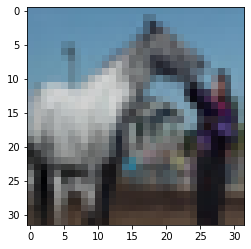

In [9]:
#原图训练集第一张
image = np.array(trainset[1][0])
import matplotlib.pyplot as plt
plt.imshow(image)

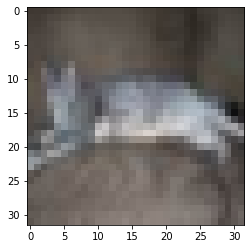

In [10]:
image = np.array(valset[1][0])
plt.imshow(image)

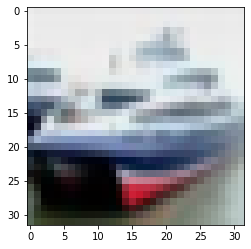

In [11]:
#测试集第一张
image = np.array(testset[1][0])
plt.imshow(image)

In [12]:
import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    return image_matrix

In [13]:
aug_types1 = albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, 
                  interpolation=1, border_mode=4, value=None, mask_value=None, 
                  shift_limit_x=None, shift_limit_y=None, always_apply=False, 
                  p=1)

aug_types2 = albu.Flip(p=1)

aug_types3 = albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, 
                  interpolation=1, border_mode=4, value=None, mask_value=None, 
                  shift_limit_x=None, shift_limit_y=None, always_apply=False, 
                  p=1)

aug_types4 = albu.Blur(blur_limit=(3,3.5), always_apply=False, p=1)

aug_types5 = albu.OneOf([
                albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50,
                                       interpolation=1, border_mode=4, value=None,mask_value=None,
                                       always_apply=False, approximate=False, p=1),
                albu.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, 
                                 value=None, mask_value=None, always_apply=False, p=1)
                        ], p=1)

In [14]:
import numpy as np
X_train = np.zeros((6*len(trainset),32,32,3))
labels=[]
for i in range(len(trainset)): 
    image=trainset[i][0]
    image = np.array(image)
    
    labels.append(trainset[i][1])
    X_train[i]=image
    X_train[i+1*len(trainset)] = augment_image(aug_types1, image)
    X_train[i+2*len(trainset)] = augment_image(aug_types2, image)
    X_train[i+3*len(trainset)] = augment_image(aug_types3, image)
    X_train[i+4*len(trainset)] = augment_image(aug_types4, image)
    X_train[i+5*len(trainset)] = augment_image(aug_types5, image)

In [15]:
import pandas as pd
y_train = np.concatenate([labels, labels, labels, labels, labels, labels],axis=0)

In [16]:
X_train[1].dtype

dtype('float64')

In [17]:
X_train[1]

array([[[ 94., 138., 173.],
        [ 94., 138., 173.],
        [ 95., 139., 173.],
        ...,
        [ 95., 141., 175.],
        [ 95., 142., 175.],
        [ 95., 143., 177.]],

       [[ 94., 140., 174.],
        [ 96., 141., 175.],
        [ 97., 142., 176.],
        ...,
        [ 98., 145., 179.],
        [ 98., 146., 179.],
        [ 97., 147., 180.]],

       [[ 94., 140., 173.],
        [ 94., 140., 173.],
        [ 96., 141., 174.],
        ...,
        [ 99., 146., 179.],
        [ 99., 146., 179.],
        [ 98., 147., 179.]],

       ...,

       [[ 60.,  52.,  46.],
        [ 34.,  31.,  29.],
        [ 19.,  19.,  20.],
        ...,
        [ 67.,  52.,  46.],
        [ 65.,  51.,  45.],
        [ 63.,  49.,  42.]],

       [[ 66.,  56.,  49.],
        [ 45.,  40.,  36.],
        [ 24.,  24.,  23.],
        ...,
        [ 83.,  66.,  56.],
        [ 81.,  65.,  56.],
        [ 81.,  65.,  55.]],

       [[ 68.,  58.,  50.],
        [ 54.,  47.,  41.],
        [ 31.,  

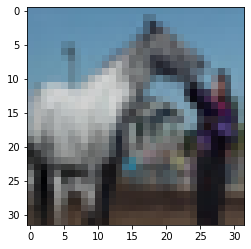

In [18]:
z_new = X_train[1].astype(np.int32)
 
plt.imshow(z_new)


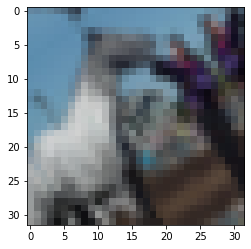

In [19]:
z_new = X_train[40001].astype(np.int32)
 
plt.imshow(z_new)

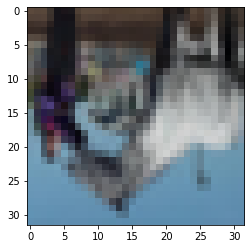

In [20]:
z_new = X_train[80001].astype(np.int32)
 
plt.imshow(z_new)

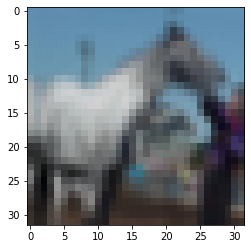

In [21]:
z_new = X_train[120001].astype(np.int32)
 
plt.imshow(z_new)

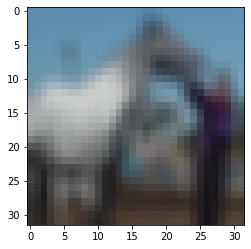

In [22]:
z_new = X_train[160001].astype(np.int32)
 
plt.imshow(z_new)

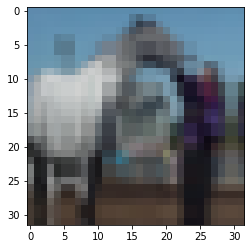

In [23]:
z_new = X_train[200001].astype(np.int32)
 
plt.imshow(z_new)

In [24]:

class AlbumentationsDataset_train():
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, labels,dataset):
        
        self.labels = labels
        self.dataset= dataset
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        #file_path = os.path.join("./train/train_pro0",self.file_paths[idx])
        
        # Read an image with OpenCV
        #image = cv2.imread(file_path)
        image= self.dataset[idx]
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #if self.transform:
        from PIL import Image
        
        image = Image.fromarray(np.uint8(image))
        image=transforms.Resize(224)(image)
        image=transforms.ToTensor()(image)
        image=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
            
        return image, label


In [25]:
train=AlbumentationsDataset_train(labels=y_train,dataset=X_train)

In [26]:
train[1]

(tensor([[[-0.5082, -0.5082, -0.5082,  ..., -0.4911, -0.4911, -0.4911],
          [-0.5082, -0.5082, -0.5082,  ..., -0.4911, -0.4911, -0.4911],
          [-0.5082, -0.5082, -0.5082,  ..., -0.4911, -0.4911, -0.4911],
          ...,
          [-0.9534, -0.9534, -0.9534,  ..., -0.5596, -0.5596, -0.5596],
          [-0.9534, -0.9534, -0.9534,  ..., -0.5596, -0.5596, -0.5596],
          [-0.9534, -0.9534, -0.9534,  ..., -0.5596, -0.5596, -0.5596]],
 
         [[ 0.3803,  0.3803,  0.3803,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.3803,  0.3803,  0.3803,  ...,  0.4678,  0.4678,  0.4678],
          ...,
          [-1.0203, -1.0203, -1.0203,  ..., -0.7577, -0.7577, -0.7577],
          [-1.0203, -1.0203, -1.0203,  ..., -0.7577, -0.7577, -0.7577],
          [-1.0203, -1.0203, -1.0203,  ..., -0.7577, -0.7577, -0.7577]],
 
         [[ 1.2108,  1.2108,  1.2108,  ...,  1.2805,  1.2805,  1.2805],
          [ 1.2108,  1.2108,

In [27]:
class AlbumentationsDataset_val():
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, dataset):
        #self.file_paths = file_paths
        #self.labels = labels
        #self.transform = transform
        self.dataset=dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        label = self.dataset[idx][1]
        #file_path = os.path.join("./train/train_pro0",self.file_paths[idx])
        
        # Read an image with OpenCV
        #image = cv2.imread(file_path)
        image= self.dataset[idx][0]
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image=transforms.Resize(224)(image)
        image=transforms.ToTensor()(image)
        image=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
        
        return image, label

In [28]:
val=AlbumentationsDataset_val(valset)

In [29]:
test=AlbumentationsDataset_val(testset)

In [30]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64,shuffle=True)
valloader=torch.utils.data.DataLoader(val, batch_size=64,shuffle=True)
testloader=torch.utils.data.DataLoader(test, batch_size=64,shuffle=True)

In [31]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=10
    ),
    
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [32]:
from torch import optim
device=torch.device("cuda")
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model=model.cuda()

In [33]:
import numpy as np
import torch
 
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
 
    def __call__(self, val_loss, model):
 
        score = -val_loss
 
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
 
    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth') # 这里会存储迄今最优模型的参数
        # torch.save(model, 'finish_model.pkl') # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

In [34]:
patience = 10
early_stopping = EarlyStopping(patience, verbose=True)
best_val_acc = -1000
best_val_model = None
for epoch in range(30):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()
        optimizer.zero_grad()
        inputs= inputs.float()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(train)},Train Acc:{running_acc*100/len(train)}%")
    
    correct = 0
    valid_loss=0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            inputs= inputs.float()
            labels=labels.cuda()
            out = model(inputs.cuda()).to(device)
            loss = criterion(out, labels)
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
            valid_loss += loss.item() * inputs.size(0)
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")

            break
        print(f"Val accuracy:{correct*100/len(val)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
   
    
print('Finished Training')  

Train loss 1: 0.8526434011300404,Train Acc:70.02583333333334%
Validation loss decreased (inf --> 4440.338778).  Saving model ...
Val accuracy:85.25%
Train loss 2: 0.5238597804347674,Train Acc:81.62166666666667%
Validation loss decreased (4440.338778 --> 3298.228481).  Saving model ...
Val accuracy:89.16%
Train loss 3: 0.40403909444411595,Train Acc:85.78875%
Validation loss decreased (3298.228481 --> 2827.989591).  Saving model ...
Val accuracy:91.0%
Train loss 4: 0.32551238426764806,Train Acc:88.47916666666667%
Val accuracy:90.66%
Train loss 5: 0.2721912808159987,Train Acc:90.33833333333334%
Val accuracy:90.21%
Train loss 6: 0.23437011851171652,Train Acc:91.68041666666667%
Val accuracy:90.41%
Train loss 7: 0.20832208034892877,Train Acc:92.655%
Val accuracy:91.97%
Train loss 8: 0.18742544393092395,Train Acc:93.36791666666667%
Val accuracy:91.37%
Train loss 9: 0.17070239475220442,Train Acc:93.94833333333334%
Val accuracy:92.37%
Train loss 10: 0.15595007806705932,Train Acc:94.535416666666

In [35]:
%%time
correct = 0
model.load_state_dict(best_val_model)
#model.load_state_dict(torch.load('checkpoint.pth'))
model.train(False)
with torch.no_grad():
    for inputs,labels in testloader:
        labels=labels.cuda()
        inputs=inputs.float()
        out = model(inputs.cuda()).to(device)
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        
        correct += acc
print(f"Test accuracy: {correct*100/len(test)}%")

Test accuracy: 92.03%
CPU times: user 32.2 s, sys: 3.05 s, total: 35.3 s
Wall time: 35.4 s
